<a href="https://colab.research.google.com/github/sayanbanerjee32/feedback-prize-effectiveness/blob/main/basic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install fastkaggle if not available
!pip install -Uq fastai
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

!pip install -Uq 'timm>=0.6.2.dev'
!pip install -Uq pynvml
from fastkaggle import *

     |████████████████████████████████| 204 kB 5.9 MB/s 
     |████████████████████████████████| 512 kB 9.9 MB/s 
     |████████████████████████████████| 46 kB 2.8 MB/s 


In [2]:
import fastai
fastai.__version__

'2.7.7'

In [3]:
# import colab libraries
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_api_auth/kaggle.json ~/.kaggle/

In [5]:
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
comp = 'feedback-prize-effectiveness'
path = setup_comp(comp)
path

100%|██████████| 8.13M/8.13M [00:00<00:00, 148MB/s]

Path('feedback-prize-effectiveness')

In [7]:
from fastai.text.all import *

In [8]:
# create data loaders
df = pd.read_csv(path/'train.csv')
dls = TextDataLoaders.from_df(df, text_col='discourse_text',
                              label_col='discourse_effectiveness')
dls.show_batch(max_n=3)

,text,category
0,xxbos xxmaj you can search the website up so that you can finished it the assignment to handle it in to your teacher if you missing anything from your others class you can finished with your others class you have with your xxunk . xxmaj if you stuck on the question go asked your teacher to helped you out now go to any comptuer that you wanted to be in you have to sign in thorugh your computer to xxunk in now you hace to wait xxunk the screen show up and now go to the website that is on your paper to finished on your assignment on your homework . \n\n xxmaj first now go to any comptuer that you wanted to be in you have to sign in thorugh your computer to xxunk in now you hace to wait xxunk the screen is done . xxmaj now listen,Ineffective
1,"xxbos xxmaj in the year 1976 , when xxmaj viking 1 space craft was taking photographs of possiable landing spots for xxmaj viking 2 spacecraft , they found a formation in a rock that looked like a human face . xxmaj the shadows made the rock look like it had a nose , mouth , and two eyes , like a human . xxmaj this was found in a region of the xxmaj red xxmaj planet called xxmaj cydonia . xxmaj the "" head "" was nearly two miles from end to end , and it seemed to be xxunk back at the cameras . \n\n xxmaj the controllers back at the xxmaj jet xxmaj propulsion xxmaj lab were probably quite surprised when this face popped up on their screens , looking them right in the eyes . xxmaj this sensation was short lived . xxmaj scientist figured it was",Ineffective
2,"xxbos the electoral college is a process , not a place . xxmaj our founding fathers had established this in the constitution as a comprise between election of the president . as said the electoral college consists of 538 electors . each candidate running for president has his or her own group of electors . 270 electoral votes is required to elect the president . xxmaj the electorals are generally chosen by the candidates political party , but varys by the state laws on what their responsibility are . xxmaj presidental election are held every 4 years on the tuesday after the first monday in november . we help choose our state electors when we vote for our president . most states have a "" winner takes all "" system that awards all electors the the xxunk candidate . xxmaj after the election , our state governor prepares a """,Adequate


SuggestedLRs(valley=0.001737800776027143, slide=0.03981071710586548)

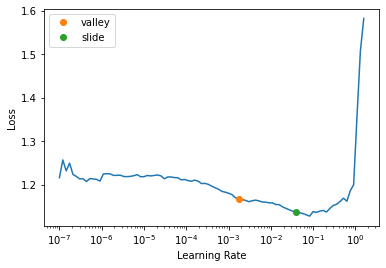

In [9]:
learn = text_classifier_learner(dls, AWD_LSTM, 
                                drop_mult=0.5,
                                metrics=[accuracy,F1ScoreMulti]).to_fp16()
learn.lr_find(suggest_funcs=(valley, slide))

In [10]:
learn.fine_tune(5, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.914513,0.875982,0.608867,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.862253,0.885406,0.583027,01:33
1,0.804737,0.781813,0.650347,01:29
2,0.752206,0.759422,0.672651,01:24
3,0.670896,0.771721,0.666667,01:32
4,0.617953,0.792312,0.663811,01:26


## Test submission

In [17]:
test_df = pd.read_csv(path/'test.csv')
test_df.rename(columns = {'discourse_text':'text'}, inplace = True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   discourse_id    10 non-null     object
 1   essay_id        10 non-null     object
 2   text            10 non-null     object
 3   discourse_type  10 non-null     object
dtypes: object(4)
memory usage: 448.0+ bytes


In [15]:
tst_dl = dls.test_dl(test_df)
tst_dl.show_batch()

,text
0,"xxbos xxmaj taking other peoples advice and doing what they say may lead to a great outcome . xxmaj when you receive other opinions whether they are good or bad you will be able to look at them from a different point of view . xxmaj for example , xxmaj when a group of people give you advice on yourself , you then know how they look at you as a person . xxmaj everyone looks at certain things from a different xxunk . xxmaj how someone else looks at it may be how its supposed to be viewed in life ."
1,"xxbos xxmaj everyone is different and may have more experience than you . xxmaj seeking other peoples opinion can cause you to gain a new skill or lesson . xxmaj for example , someones advice could teach you how to do something the correct way . xxmaj many people are very different and have experience different things in life . xxmaj seeking advice from others can teach you a lot . xxmaj we all learn from our mistakes in life , by sharing your past experiences you may prevent someone else from making the same mistake ."
2,xxbos xxmaj when making a decision there is a chance that you can become very stressed and overwhelmed . xxmaj being stressed can cause a person to give up on what they are doing . xxmaj having multiple opinions from people can make choosing an option less difficult and more easier . xxmaj the information that you receive from others may have a special meaning in the future . xxmaj other peoples opinion can make a person feel confident in making the right choice .
3,xxbos xxmaj you can learn from others experiences by seeking the advice that someone give you . xxmaj making decisions can cause stress on a person . xxmaj relating to someones advice may higher your self - esteem because you no longer feel left out . xxmaj ask others for advice when making a difficult decision . xxmaj when you seek others opinion more opportunities are available fro yourself .
4,xxbos xxmaj making choices in life can be very difficult . xxmaj people often ask for advice when they can not decide on one thing . xxmaj it 's always good to ask others for their advice when making a choice . xxmaj when you have multiple opinions you have the ability to make the best choice for yourself .
5,xxbos xxmaj seeking multiple opinions can help a person make a better choice
6,xxbos xxmaj seeking others opinion can be very helpful and beneficial .
7,xxbos a great chance to learn something new
8,xxbos can be very helpful and beneficial .


In [16]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
probs

tensor([[0.1818, 0.8163, 0.0019],
        [0.6783, 0.2756, 0.0462],
        [0.5162, 0.0522, 0.4316],
        [0.6223, 0.2570, 0.1207],
        [0.5162, 0.0522, 0.4316],
        [0.3629, 0.6282, 0.0089],
        [0.2409, 0.7580, 0.0011],
        [0.6853, 0.2604, 0.0544],
        [0.6561, 0.2896, 0.0543],
        [0.2425, 0.7559, 0.0016]])

In [19]:
# column names for probabilities
dls.vocab[1]

['Adequate', 'Effective', 'Ineffective']

In [ ]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

In [ ]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'initial', comp)